In [1]:
import os
import torch
import json
import torch, math
from io import BytesIO
import numpy as np
import torch.nn as nn
import imageio.v2 as imageio
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from psipy.model import MASOutput
from pyhdf.SD import SD, SDC
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import RegularGridInterpolator

## Reading manually

In [2]:
def read_hdf(hdf_path, dataset_names):
    f = SD(hdf_path, SDC.READ)
    datasets = []
    for dataset_name in dataset_names:
        datasets.append(f.select(dataset_name).get())
    return datasets

In [3]:
sim_path = "/Users/reza/Career/DMLab/SURROGATE/sun-sim/src/sfno/mhd/vr_rho_pinn/cr1833-all-components/kpo_mas_mas_std_0101"
cr_num = '1833'

vr, vr_phi, vr_theta, vr_r = read_hdf(
    f"{sim_path}/vr002.hdf", ["Data-Set-2", "fakeDim0", "fakeDim1", "fakeDim2"]
)
rho, rho_phi, rho_theta, rho_r = read_hdf(
    f"{sim_path}/rho002.hdf", ["Data-Set-2", "fakeDim0", "fakeDim1", "fakeDim2"]
)
p, p_phi, p_theta, p_r = read_hdf(
    f"{sim_path}/p002.hdf", ["Data-Set-2", "fakeDim0", "fakeDim1", "fakeDim2"]
)
jr, jr_phi, jr_theta, jr_r = read_hdf(
    f"{sim_path}/jr002.hdf", ["Data-Set-2", "fakeDim0", "fakeDim1", "fakeDim2"]
)
br, br_phi, br_theta, br_r = read_hdf(
    f"{sim_path}/br002.hdf", ["Data-Set-2", "fakeDim0", "fakeDim1", "fakeDim2"]
)


print(
    "\nvr.shape: ",
    vr.shape,
    "\nrho.shape: ",
    rho.shape,
    "\np.shape: ",
    p.shape,
    "\njr.shape: ",
    jr.shape,
    "\nbr.shape: ",
    br.shape,
)


vr.shape:  (128, 111, 140) 
rho.shape:  (128, 111, 141) 
p.shape:  (128, 111, 141) 
jr.shape:  (128, 111, 140) 
br.shape:  (128, 110, 141)


In [4]:
new_r = rho_r # also = jr_r
new_theta = vr_theta

print(new_r.shape, new_theta.shape)

(141,) (111,)


In [5]:
def interpolate_cube(data, x_old, y_old, z_old, x_new, y_new, z_new):
    interp_func = RegularGridInterpolator(
        (x_old, y_old, z_old),
        data,
        method="linear",
        bounds_error=False,
        fill_value=None,
    )
    xg, yg, zg = np.meshgrid(x_new, y_new, z_new, indexing="ij")
    points_new = np.stack([xg.ravel(), yg.ravel(), zg.ravel()], axis=-1)
    data_new_flat = interp_func(points_new)
    data_new = data_new_flat.reshape((len(x_new), len(y_new), len(z_new)))
    return data_new

In [6]:
vr = interpolate_cube(vr, x_old=vr_phi, y_old=vr_theta, z_old=vr_r, x_new=vr_phi, y_new=vr_theta, z_new=new_r)
jr = interpolate_cube(jr, x_old=jr_phi, y_old=jr_theta, z_old=jr_r, x_new=jr_phi, y_new=jr_theta, z_new=new_r)
br = interpolate_cube(br, x_old=br_phi, y_old=br_theta, z_old=br_r, x_new=br_phi, y_new=new_theta, z_new=br_r)

In [7]:
vr = np.transpose(vr, (2, 1, 0))
rho = np.transpose(rho, (2, 1, 0))
p = np.transpose(p, (2, 1, 0))
br = np.transpose(br, (2, 1, 0))
jr = np.transpose(jr, (2, 1, 0))

print(
    "\nvr.shape: ",
    vr.shape,
    "\nrho.shape: ",
    rho.shape,
    "\np.shape: ",
    p.shape,
    "\njr.shape: ",
    jr.shape,
    "\nbr.shape: ",
    br.shape,
)


vr.shape:  (141, 111, 128) 
rho.shape:  (141, 111, 128) 
p.shape:  (141, 111, 128) 
jr.shape:  (141, 111, 128) 
br.shape:  (141, 111, 128)


## Conversion to cgs

In [8]:
# r = new_r
# if 'unit' in locals():
#     raise NameError("RESTART NOTEBOOK")
# unit = 'cgs'

# # Equation 6
# r = r * 6.96 * 1e10         # cm
# vr = vr * 481.3711 * 1e5    # cm / s
# rho = rho * 1.6726 * 1e-16  # g / cm^3
# p = p * 0.3875717           # dyn / cm^2
# jr = jr * 0.07558           # statamp / cm^2
# br = br * 2.2068908         # Gauss
# G = 6.67430 * 1e-8          # cm^3 / (g * s^2)
# M_sun = 1.9885 * 1e33       # g
# omega_rot = 2.84 * 1e-6     # rad / s
# c = 2.99792458e10           # cm / s
# viscosity = 5.0 * 1e-3 * 3.350342628857710e+18     # cm^2 /s Pete: Viscosity (nu) is in code units when expressed as 0.005). Since the units are l^2/t, in cgs, that’s cm^2/s. From the table, that’s (6.96E10)^2/1445.87, or 3.350342628857710e+18 cm^2/s in the cgs system. So, you need to multiply 0.005 by this number to get the value in cgs.

# # Equation 1
# eq_1_multiplier = 4 * np.pi / c

# # Equation 7
# gamma = 1.5

## Conversion to MKS

In [9]:
r = new_r
if 'unit' in locals():
    raise NameError("RESTART NOTEBOOK")
unit = 'mks'

# Equation 6
r = r * 6.96 * 1e8           # m
vr = vr * 481.3711 * 1e3     # m / s
rho = rho * 1.6726 * 1e-13   # kg / m^3
p = p * 0.03875717           # Pascals (N / m^2)
jr = jr * 2.52 * 1e-7        # * 2.267 * 1e4 (MAS Guide)       # A / m^2
br = br * 2.2068908 * 1e-4   # Tesla
G = 6.67430 * 1e-11          # m^3 / (kg * s^2)
M_sun = 1.9885 * 1e30        # kg
omega_rot = 2.84 * 1e-6      # rad / s
c = 2.99792458 * 1e8         # m / s
viscosity = 5.0 * 1e-7 * 3.350342628857710e+18      # m^2 / s

# Equation 1
eq_1_multiplier = 4 * np.pi * 1e-7

# Equation 7
gamma = 1.5

In [10]:
# instance_path = '/Users/reza/Career/DMLab/SURROGATE/sun-sim/src/sfno/mhd/vr_rho_pinn/cr1833-all-components/kpo_mas_mas_std_0101'

In [11]:
# model = MASOutput(instance_path)

In [12]:
# vr_model = model["vr"]
# rho_model = model["rho"]
# pressure_model = model["p"]
# jr_model = model["jr"]
# br_model = model["br"]

# p = np.array(rho_model.phi_coords)
# # sin(theta) - (-pi/2, pi/2)
# t = np.array(rho_model.theta_coords)
# # 30 solar radii to approximately 1 AU
# r = np.array(rho_model.r_coords) * 6.96 * 1e10
# # velocity profile
# old_r = np.array(vr_model.r_coords) * 6.96 * 1e10
# old_t = np.array(br_model.theta_coords)


# print('vr:', model.get_unit("vr"), '\nrho:', model.get_unit('rho'), '\nP:', model.get_unit('p'), '\njr:', model.get_unit('jr'), '\nbr', model.get_unit('br'), '\nr:', model.get_runit())


# vr = np.array(vr_model.data.squeeze())
# jr = np.array(jr_model.data.squeeze())
# br = np.array(br_model.data.squeeze())
# rho = np.array(rho_model.data.squeeze())
# pressure = np.array(pressure_model.data.squeeze())

# print(
#     "\nvr.shape: ",
#     vr.shape,
#     "\njr.shape: ",
#     jr.shape,
#     "\nbr.shape: ",
#     br.shape,
#     "\nrho.shape: ",
#     rho.shape,
#     "\npressure.shape: ",
#     pressure.shape,
#     "\np.shape: ",
#     p.shape,
#     "\nt.shape: ",
#     t.shape,
#     "\nr.shape: ",
#     r.shape,
#     "\nold_r.shape: ",
#     old_r.shape,
#     "\nold_t.shape: ",
#     old_t.shape,
# )

In [13]:
# for i, rx in enumerate(r):
#     print(rx, rx/696_000, i)
#     if i % 35 == 0:
#         print('-'*10)

In [14]:
# p[-1] - p[0], p.shape

In [15]:
# r[-1] - r[0], r.shape

In [16]:
# t[-1] - t[0], t.shape

In [17]:
# r[-3:]

In [18]:
# old_r[-3:]

In [19]:
# plt.imshow(vr[:, :, 0].T, cmap='gnuplot')
# plt.show()
# plt.imshow(rho[:, :, 0].T, cmap='gnuplot')
# plt.show()
# plt.imshow(p[:, :, 0].T, cmap='gnuplot')
# plt.show()
# plt.imshow(br[:, :, 0].T, cmap='gnuplot')
# plt.show()
# plt.imshow(jr[:, :, 0].T, cmap='gnuplot')
# plt.show()

In [20]:
# vr = np.transpose(vr, (2, 1, 0))
# rho = np.transpose(rho, (2, 1, 0))
# pressure = np.transpose(pressure, (2, 1, 0))
# br = np.transpose(br, (2, 1, 0))
# jr = np.transpose(jr, (2, 1, 0))

# print(vr.shape, rho.shape, pressure.shape, jr.shape, br.shape)

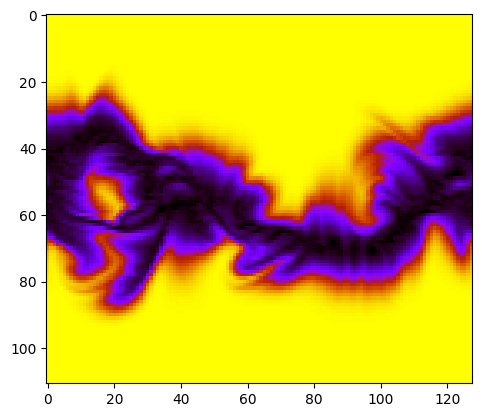

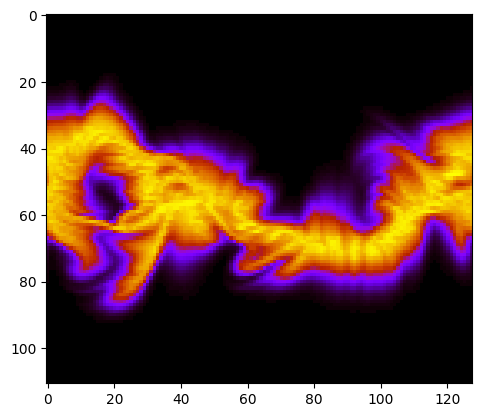

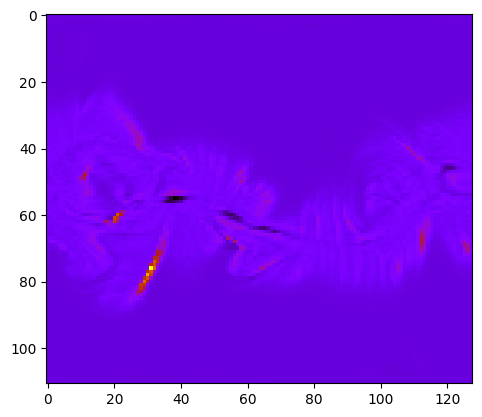

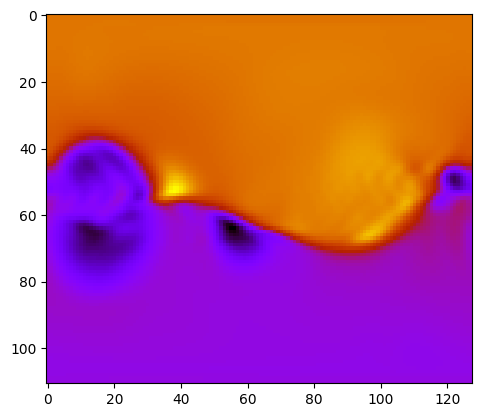

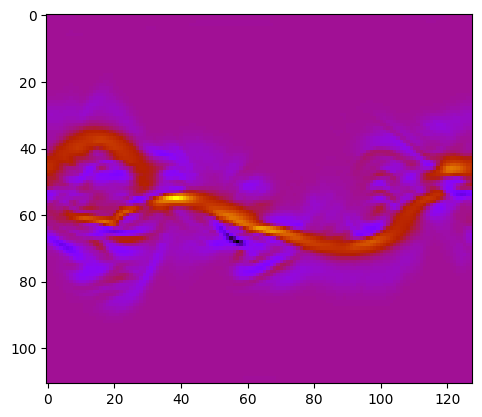

In [21]:
plt.imshow(vr[0], cmap='gnuplot')
plt.show()
plt.imshow(rho[0], cmap='gnuplot')
plt.show()
plt.imshow(p[0], cmap='gnuplot')
plt.show()
plt.imshow(br[0], cmap='gnuplot')
plt.show()
plt.imshow(jr[0], cmap='gnuplot')
plt.show()

In [22]:
def fft_gradient(f: torch.Tensor, dr: float, dim: int = 0) -> torch.Tensor:

    Nr = f.shape[dim]

    # --- FFT along the radial axis ------------------------------------------
    v_hat = torch.fft.fft(f, dim=dim)  # complex spectrum

    # --- build wavenumber array k -------------------------------------------
    k_1d = 2 * math.pi * torch.fft.fftfreq(Nr, d=dr, device=f.device)  # (Nr,)
    # reshape to broadcast into v_hat (insert singleton dims)
    shape = [1] * f.ndim
    shape[dim] = Nr
    k = k_1d.reshape(*shape)

    # --- multiply by i·k in spectral space -----------------------------------
    dv_hat = 1j * k * v_hat

    # --- back-transform -------------------------------------------------------
    dv_dr = torch.fft.ifft(dv_hat, dim=dim).real  # discard imag noise

    return dv_dr

In [23]:
def test_fft_gradient_sine():
    Nr = 128
    dr = 0.1
    L = Nr * dr
    m = 3  # integer number of cycles for periodicity
    k_wave = 2 * math.pi * m / L
    x = torch.arange(Nr) * dr

    f = torch.sin(k_wave * x)
    expected = k_wave * torch.cos(k_wave * x)

    result = fft_gradient(f, dr)

    # Slightly relaxed tolerances for floating-point noise
    torch.testing.assert_close(result, expected, rtol=1e-5, atol=3e-5)

def test_fft_gradient_multidim():
    Nr, Ny = 64, 8
    dr = 0.05
    L = Nr * dr
    m = 5  # integer number of sine cycles in radial direction
    k_wave = 2 * math.pi * m / L

    r = torch.arange(Nr) * dr
    y = torch.arange(Ny)

    # 2D function varying only along radial axis (dim=0)
    f = torch.sin(k_wave * r)[:, None] * (1 + 0*y[None, :])
    expected = (k_wave * torch.cos(k_wave * r))[:, None] * (1 + 0*y[None, :])

    # Compute FFT gradient along dim=0
    result = fft_gradient(f, dr, dim=0)

    torch.testing.assert_close(result, expected, rtol=1e-5, atol=3e-5)

test_fft_gradient_sine()
test_fft_gradient_multidim()

In [24]:
def finite_diff_gradient(f, coords, axis):
    f = f.movedim(axis, 0)  # bring the axis to front, shape: (n, ...)
    df = torch.empty_like(f)

    for idx in torch.cartesian_prod(*[torch.arange(s) for s in f.shape[1:]]):
        idx_tuple = tuple(idx.tolist())
        line = f[(slice(None),) + idx_tuple]       # 1D slice along coords
        d = torch.empty_like(line)

        # central difference
        d[1:-1] = (line[2:] - line[:-2]) / (coords[2:] - coords[:-2])
        # forward/backward for boundaries
        d[0] = (line[1] - line[0]) / (coords[1] - coords[0])
        d[-1] = (line[-1] - line[-2]) / (coords[-1] - coords[-2])

        df[(slice(None),) + idx_tuple] = d

    return df.movedim(0, axis)


In [25]:
x = torch.linspace(0, 2, 100)**1.5     # non-uniform grid
y = torch.linspace(0, 1, 50)
z = torch.linspace(0, 1, 40)

X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')
f = torch.sin(X) * torch.exp(Y) * Z**2

# Compute df/dx
df_dx = finite_diff_gradient(f, x, axis=0)

# Compare to analytical df/dx
df_dx_true = torch.cos(X) * torch.exp(Y) * Z**2

# Error
err = torch.abs(df_dx - df_dx_true).mean()
print(f"expect a low error (~1e-3 to 1e-5). Mean abs error: {err.item():.3e}")

expect a low error (~1e-3 to 1e-5). Mean abs error: 1.160e-04


In [26]:
# def loss_time_derivative_equals_zero(vr_pred, rho_pred, pressure, dr, g):
        
#         vr_pred = vr_pred.double()
#         rho_pred = rho_pred.double()
#         pressure = pressure.double()

#         radial_dim = 1 if vr_pred.ndim == 4 else 0
        
#         # dv_phi_dphi = fft_gradient(vr_pred, 2 * torch.pi / 360, radial_dim=-1)

#         dv_r_dr = fft_gradient(vr_pred, dr, dim=radial_dim)
#         # First derivative of v_r (radial velocity) w.r.t. r (along axis 0)
#         d_p_dr = fft_gradient(pressure, dr, dim=radial_dim)
#         # First derivative of pressure w.r.t. r (1D array)

#         # term0 = rho_pred * dv_phi_dphi #/ np.broadcast_to(self.r[:, np.newaxis, np.newaxis], (140, 111, 128))
#         term1 = rho_pred * vr_pred * dv_r_dr  # Convective term: rho * v_r * (dv_r / dr)
#         term2 = -d_p_dr  # Pressure gradient term: - dp / dr
#         print(rho_pred.shape, g.shape)
#         term3 = rho_pred * g  # Gravitational term: rho * g

#         value = term2 + term3 - term1 #- term0
        
#         print("Term magnitudes:")
#         # print("Periodic term (rho * dvphi/dphi / r):", term0.abs().mean().item())
#         print("Convective term (rho * v * dv/dr):", term1.abs().mean().item())
#         print("Pressure gradient term (-dp/dr):", term2.abs().mean().item())
#         print("Gravitational term (rho * g):", term3.abs().mean().item())
#         print("Residual value:", value.abs().mean().item())

#         return value

In [27]:
# def phys_loss_ignorant(vr_pred, rho_pred, pressure, radii, phis, g, omega):

#     vr_pred = vr_pred.double()
#     rho_pred = rho_pred.double()
#     pressure = pressure.double()

#     dv_r_dphi = fft_gradient(vr_pred, phis[1] - phis[0], 2)
#     dv_r_dr = finite_diff_gradient(vr_pred, radii, 0)
#     d_p_dr = finite_diff_gradient(pressure, radii, 0)

#     term0 = -omega * dv_r_dphi
#     term1 = vr_pred * dv_r_dr  # Convective term: rho * v_r * (dv_r / dr)
#     term2 = -d_p_dr / rho_pred  # Pressure gradient term: - dp / dr
#     term3 = -g  # Gravitational term: rho * g

#     value = term2 + term3 - term1 - term0
#     # value = -term1 - term0
#     # value = term2 - term1 - term0

#     print("Term magnitude means:")
#     print("Periodic term (omega * dvr/dphi):", term0.abs().mean().item())
#     print("Convective term (v * dv/dr):", term1.abs().mean().item())
#     print("Pressure gradient term (-1/rho*dp/dr):", term2.abs().mean().item())
#     print("Gravitational term (-GMs/r^2):", term3.abs().mean().item())
#     print("Residual value:", value.abs().mean().item())

#     return value.abs()


def eq_1(br_pred, jr_pred, radii, thetas, phis, multiplier):
    """
    Compute mean absolute residuals of Ampère's law components:
        ∇ × B - multiplier * J = 0
    assuming Bθ = Bφ = 0 and only Br is nonzero.

    Returns:
        res_r_scalar, res_theta_scalar, res_phi_scalar: three scalar residuals
    """

    br_pred = br_pred.double()
    jr_pred = jr_pred.double()

    # --- Derivatives ---
    dBr_dtheta = finite_diff_gradient(br_pred, thetas, axis=1)
    dBr_dphi = fft_gradient(br_pred, phis[1] - phis[0], dim=2)

    # --- Avoid poles ---
    sin_theta = torch.sin(thetas)
    sin_theta = torch.where(sin_theta == 0, torch.tensor(1e-10, dtype=torch.double), sin_theta)

    r = radii[:, None, None]
    sinθ = sin_theta[None, :, None]

    # --- Compute curl components ---
    curl_r = torch.zeros_like(br_pred)
    curl_theta = (1.0 / (r * sinθ)) * dBr_dphi
    curl_phi = -(1.0 / r) * dBr_dtheta

    # --- RHS ---
    rhs_r = multiplier * jr_pred
    rhs_theta = torch.zeros_like(jr_pred)
    rhs_phi = torch.zeros_like(jr_pred)

    # --- Residual components ---
    res_r = curl_r - rhs_r
    res_theta = curl_theta - rhs_theta
    res_phi = curl_phi - rhs_phi
    
    print(f"Mean |lhs_r|: {curl_r.abs().mean().item():.3e}")
    print(f"Mean |lhs_theta|: {curl_theta.abs().mean().item():.3e}")
    print(f"Mean |lhs_phi|: {curl_phi.abs().mean().item():.3e}")
    
    print(f"Mean |rhs_r|: {rhs_r.abs().mean().item():.3e}")
    print(f"Mean |rhs_theta|: {rhs_theta.abs().mean().item():.3e}")
    print(f"Mean |rhs_phi|: {rhs_phi.abs().mean().item():.3e}")
    
    print(f"Mean |residual_r|: {res_r.abs().mean().item():.3e}")
    print(f"Mean |residual_theta|: {res_theta.abs().mean().item():.3e}")
    print(f"Mean |residual_phi|: {res_phi.abs().mean().item():.3e}")

    residual_magnitude = torch.sqrt(res_r**2 + res_theta**2 + res_phi**2)
    
    print(f"Mean |residual|: {residual_magnitude.abs().mean().item():.3e}")

    return residual_magnitude


def eq_6(
    vr_pred, rho_pred, pressure, jr_pred, br_pred, radii, phis, g, omega, c, viscosity
):

    vr_pred = vr_pred.double()
    rho_pred = rho_pred.double()
    pressure = pressure.double()
    jr_pred = jr_pred.double()
    br_pred = br_pred.double()

    dv_r_dphi = fft_gradient(vr_pred, phis[1] - phis[0], 2)
    dv_r_dr = finite_diff_gradient(vr_pred, radii, 0)
    d_p_dr = finite_diff_gradient(pressure, radii, 0)
    viscos_term = viscosity * rho_pred * dv_r_dr
    d_viscos = finite_diff_gradient(viscos_term, radii, 0)

    term0 = rho_pred * (-omega * dv_r_dphi)
    term1 = rho_pred * vr_pred * dv_r_dr  # Convective term: rho * v_r * (dv_r / dr)
    term2 = jr_pred / c * br_pred
    term3 = -d_p_dr
    term4 = rho_pred * g  # Gravitational term: rho * g. # torch.tensor(0, dtype=torch.float32)
    term5 = d_viscos

    value = term2 + term3 + term4 + term5 - term1 - term0
    # value = -term1 - term0
    # value = term2 - term1 - term0

    print("Term magnitude means:")
    print("rho * -omega * dv_r_dphi:", term0.abs().mean().item())
    print("rho * vr * dv_r_dr:", term1.abs().mean().item())
    print("jr / c * br:", term2.abs().mean().item())
    print("-d_p_dr:", term3.abs().mean().item())
    print("rho * g:", term4.abs().mean().item())
    print("viscosity term:", term5.abs().mean().item())
    print("Residual:", value.abs().mean().item())

    return value.abs(), (term0.abs(), term1.abs(), term2.abs(), term3.abs(), term4.abs(), term5.abs())

In [28]:
gravity = G * M_sun / (r**2)
print(gravity.shape)
gravity = np.broadcast_to(gravity[:, np.newaxis, np.newaxis], (141, 111, 128))
print(gravity.shape)

(141,)
(141, 111, 128)


In [29]:
_vr = torch.tensor(vr)
_rho = torch.tensor(rho)
_pressure = torch.tensor(p)
_jr = torch.tensor(jr)
_br = torch.tensor(br)
_gravity = torch.tensor(gravity)
_r = torch.tensor(r)
_phi = torch.tensor(vr_phi)
_theta = torch.tensor(vr_theta)


In [30]:
# (loss, terms) = eq_6(
#     _vr,
#     _rho,
#     _pressure,
#     _jr,
#     _br,
#     _r,
#     _phi,
#     _gravity,
#     omega=omega_rot,
#     c=c,
#     viscosity=viscosity,
# )
# eq = 'eq6'

loss = eq_1(_br, _jr, _r, _theta, _phi, eq_1_multiplier)
eq = 'eq1'

Mean |lhs_r|: 0.000e+00
Mean |lhs_theta|: 2.155e-19
Mean |lhs_phi|: 3.955e-19
Mean |rhs_r|: 1.984e-19
Mean |rhs_theta|: 0.000e+00
Mean |rhs_phi|: 0.000e+00
Mean |residual_r|: 1.984e-19
Mean |residual_theta|: 2.155e-19
Mean |residual_phi|: 3.955e-19
Mean |residual|: 5.534e-19


In [31]:
# frames = []

# loss_min, loss_max = torch.min(loss), torch.max(loss)

# for i in trange(vr.shape[0]): # (1, 238, 2) for rho
#     vv = vr[i, :, :]
#     rhorho = rho[i, :, :]
#     jj = jr[i, :, :]
#     bb = br[i, :, :]
#     pp = p[i, :, :]


#     error = loss[i, :, :].cpu().numpy()
    
#     fig, axes = plt.subplots(1, 6, figsize=(12, 4), constrained_layout=True)
#     cmap = "gnuplot"

#     # # Plot first subplot
#     im1 = axes[0].imshow(vv, cmap=cmap) #, vmin=vr_min, vmax=vr_max)
#     axes[0].set_title(f"vr002 at {i+1}")

#     # Plot second subplot
#     im2 = axes[1].imshow(rhorho, cmap=cmap) #, vmin=rho_min, vmax=rho_max)
#     axes[1].set_title(f"rho002 at {i+1}")

#     # Plot second subplot
#     im3 = axes[2].imshow(jj, cmap=cmap) #, vmin=jr_min, vmax=jr_max)
#     axes[2].set_title(f"jr002 at {i+1}")

#     # Plot second subplot
#     im4 = axes[3].imshow(bb, cmap=cmap) #, vmin=br_min, vmax=br_max)
#     axes[3].set_title(f"br002 at {i+1}")

#     # Plot second subplot
#     im5 = axes[4].imshow(pp, cmap=cmap) #, vmin=pressure_min, vmax=pressure_max)
#     axes[4].set_title(f"p002 at {i+1}")

#     # Plot second subplot
#     # im6 = axes[5].imshow(error, cmap="gray", vmin=loss_min, vmax=loss_max)
#     # scale = 'global'
    
#     im6 = axes[5].imshow(error, cmap="gray")
#     scale = 'local'
    
#     axes[5].set_title(f"static equation 6")
    
#     fig.suptitle(f'slice mean error: {error.mean()}')

#     # Create a single colorbar
#     cbar = fig.colorbar(im6, ax=axes, orientation="horizontal", fraction=0.05, pad=0.02)
    
#     for ax in axes:
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_xlabel("")
#         ax.set_ylabel("")

#     # plt.tight_layout()
#     buf = BytesIO()
#     plt.savefig(buf, format="png")
#     frames.append(imageio.imread(buf))
#     plt.close()
    

# output_filename = f"{eq}-cr{cr_num}-{scale}-{unit}.gif"
# fps = 8  # Adjust frames per second as needed

# # Create video directly from frames in memory
# with imageio.get_writer(output_filename, fps=fps, loop=0) as writer:
#     for frame in frames:
#         writer.append_data(frame)

In [33]:
frames = []

loss_min, loss_max = torch.min(loss), torch.max(loss)

for i in trange(br.shape[0]): # (1, 238, 2) for rho
    jj = jr[i, :, :]
    bb = br[i, :, :]


    error = loss[i, :, :].cpu().numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(6, 4), constrained_layout=True)
    cmap = "gnuplot"

    # Plot second subplot
    im3 = axes[0].imshow(jj, cmap=cmap) #, vmin=jr_min, vmax=jr_max)
    axes[0].set_title(f"jr002 at {i+1}")

    # Plot second subplot
    im4 = axes[1].imshow(bb, cmap=cmap) #, vmin=br_min, vmax=br_max)
    axes[1].set_title(f"br002 at {i+1}")

    # Plot second subplot
    # im6 = axes[2].imshow(error, cmap="gray", vmin=loss_min, vmax=loss_max)
    # scale = 'global'
    
    im6 = axes[2].imshow(error, cmap="gray")
    scale = 'local'
    
    axes[2].set_title(f"static equation 1")
    
    fig.suptitle(f'slice mean error: {error.mean()}')

    # Create a single colorbar
    cbar = fig.colorbar(im6, ax=axes, orientation="horizontal", fraction=0.05, pad=0.02)
    
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")

    # plt.tight_layout()
    buf = BytesIO()
    plt.savefig(buf, format="png")
    frames.append(imageio.imread(buf))
    plt.close()
    

output_filename = f"{eq}-cr{cr_num}-{scale}-{unit}.gif"
fps = 8  # Adjust frames per second as needed

# Create video directly from frames in memory
with imageio.get_writer(output_filename, fps=fps, loop=0) as writer:
    for frame in frames:
        writer.append_data(frame)

100%|██████████| 141/141 [00:21<00:00,  6.55it/s]
